# Study Query LLM - PCA KLLMeans Analysis & Visualization

This notebook loads previously saved sweep results from pickle files and provides:
1. Visualization of stability metrics across K values and summarizers
2. Data comparison and validation
3. Representative text comparison across summarizers
4. Custom analysis of results

**Prerequisites:** Run `pca_kllmeans_sweep.ipynb` first to generate pickle files.

## Install dependencies (REQUIRED - Run this first!)

**IMPORTANT:** You must install the package dependencies before running the notebook.

In [1]:
# Install the package in editable mode
%pip install -e ..

# After installation, restart the kernel (Kernel -> Restart Kernel) and run cells from the top

Obtaining file:///C:/Users/spenc/Cursor%20Repos/study-query-llm
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for study-query-llm (pyproject.toml): started
  Building editable for study-query-llm (pyproject.toml): finished with status 'done'
  Created wheel for study-query-llm: filename=study_query_llm-0.1.0-0.editable-py3-none-any.whl size=5140 sha256=effd5017ec53663b57c797f26d0e1ad354bda3b15487b80809336660c3e09b92
  Stored in directory: C:\Users\spenc\AppData\Local\Temp\pip-ephem-wheel-cache-1a3ggt_f\wheels\c9\27\94\899557

## Load Results from Pickle File

In [2]:
import pickle
import numpy as np
from pathlib import Path

# Option 1: Specify the exact filename
# saved_file = "pca_kllmeans_sweep_results_20260204_231913.pkl"

# Option 2: Load the most recent pickle file (default)
pickle_files = sorted(Path(".").glob("pca_kllmeans_sweep_results_*.pkl"), reverse=True)
if pickle_files:
    saved_file = pickle_files[0]
    print(f"📂 Loading results from: {saved_file}")
    
    with open(saved_file, "rb") as f:
        results = pickle.load(f)
    
    print(f"[OK] Loaded {len(results)} summarizer(s): {list(results.keys())}")
    
    # Show structure
    if results:
        first_key = list(results.keys())[0]
        first_data = results[first_key]
        if 'by_k' in first_data:
            k_values = sorted([int(k) for k in first_data['by_k'].keys()])
            print(f"   K values: {k_values}")
            print(f"   Example access: results['{first_key}']['by_k']['{k_values[0]}']['stability']")
else:
    print("[ERROR] No pickle files found. Run pca_kllmeans_sweep.ipynb first to generate results.")
    results = {}

📂 Loading results from: pca_kllmeans_sweep_results_20260204_235444.pkl
[OK] Loaded 4 summarizer(s): ['None', 'gpt-4o-mini', 'gpt-4o', 'gpt-5-chat-2025-08-07']
   K values: [2, 3, 4, 5, 6, 7, 8, 9, 10]
   Example access: results['None']['by_k']['2']['stability']


## Visualize Stability Metrics

Create visualizations of stability metrics across K values and summarizers.

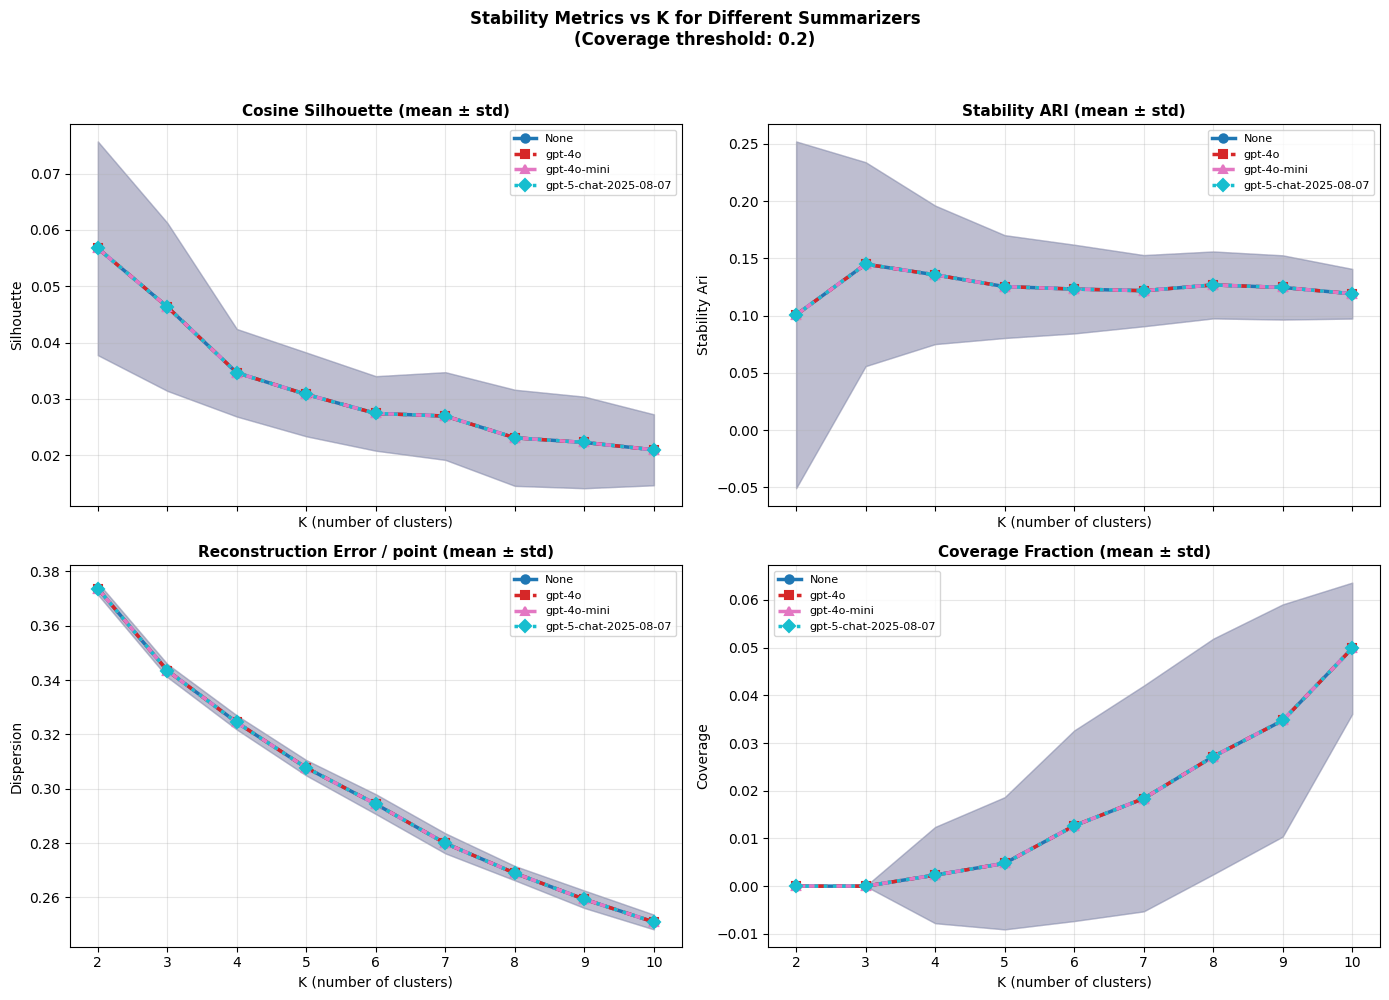


[OK] Visualized 4 summarizer(s) across K values


In [3]:
import matplotlib.pyplot as plt
import numpy as np

if results:
    metrics_to_plot = [
        ("silhouette", "Cosine Silhouette (mean ± std)"),
        ("stability_ari", "Stability ARI (mean ± std)"),
        ("dispersion", "Reconstruction Error / point (mean ± std)"),
        ("coverage", "Coverage Fraction (mean ± std)"),
    ]
    
    # Get coverage threshold from saved data if available
    coverage_threshold = 0.2  # Default, update if stored in results
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.flatten()
    
    # Use different line styles and markers to distinguish overlapping lines
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h']
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    
    for ax, (metric_key, title) in zip(axes, metrics_to_plot):
        plotted_count = 0
        for idx, summarizer_name in enumerate(sorted(results.keys())):
            try:
                k_data = results[summarizer_name]["by_k"]
                ks = sorted([int(k) for k in k_data.keys() if k_data[k].get("stability")])
                
                if not ks:
                    continue
                    
                means = []
                stds = []
                valid_ks = []
                
                for k in ks:
                    stability = k_data[str(k)].get("stability")
                    if stability and metric_key in stability:
                        means.append(stability[metric_key]["mean"])
                        stds.append(stability[metric_key]["std"])
                        valid_ks.append(k)
                
                if valid_ks:
                    # Use different styles for each summarizer
                    style_idx = idx % len(line_styles)
                    marker_idx = idx % len(markers)
                    color = colors[idx]
                    
                    ax.plot(
                        valid_ks, means, 
                        marker=markers[marker_idx],
                        linestyle=line_styles[style_idx],
                        label=summarizer_name, 
                        linewidth=2.5,
                        color=color,
                        markersize=6,
                        markeredgewidth=1.5
                    )
                    ax.fill_between(
                        valid_ks,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        alpha=0.15,
                        color=color
                    )
                    plotted_count += 1
            except Exception as e:
                print(f"[WARN]  Error plotting {summarizer_name} for {metric_key}: {e}")
                continue
        
        if plotted_count == 0:
            print(f"[WARN]  No data to plot for {metric_key}")
        
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_xlabel("K (number of clusters)", fontsize=10)
        ax.set_ylabel(metric_key.replace('_', ' ').title(), fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    # Add overall title
    fig.suptitle(
        f"Stability Metrics vs K for Different Summarizers\n"
        f"(Coverage threshold: {coverage_threshold})",
        fontsize=12,
        fontweight='bold',
        y=0.995
    )
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    print(f"\n[OK] Visualized {len(results)} summarizer(s) across K values")
else:
    print("[WARN]  No results to visualize")

In [4]:
# Compare representatives for a specific K value
K_TO_COMPARE = 5

print(f"\n{'='*60}")
print(f"Comparing representatives for K={K_TO_COMPARE}")
print(f"{'='*60}")

for summarizer_name in sorted(results.keys()):
    if str(K_TO_COMPARE) in results[summarizer_name]["by_k"]:
        reps = results[summarizer_name]["by_k"][str(K_TO_COMPARE)].get("representatives", [])
        print(f"\n{summarizer_name}:")
        for i, rep in enumerate(reps, 1):
            print(f"  {i}. {rep[:120]}{'...' if len(rep) > 120 else ''}")


Comparing representatives for K=5

None:
  1. ../../../Templates/YAML_formatting_prompt.md
  2. I have this yaml file that contains 25 problems. I would like you to check and update three things about each question:
...
  3. Using the data from table 2, create a word problem for each row describing a reasonable scenario in which the object und...
  4. Write the question body for each of the 10 scenarios above, stating that the trajectories are shown in the figure, and a...
  5. I have an md file containing the problem body of 12 linear momentum conservation problems, and a csv file containing the...

gpt-4o:
  1. How should I format YAML files according to the provided template?
  2. Can you review and update the first five problems in this YAML file by ensuring the following: (1) the problem context i...
  3. How many revolutions does the object complete if it undergoes motion with constant angular acceleration as described in ...
  4. For each of the 10 scenarios depicted in the fig

## Test: Check if Data is Identical or Just Very Close

Test whether summarizers have truly identical data (bit-for-bit) or if values are just very close (within floating-point precision).

In [5]:
import numpy as np

if results:
    print(f"\n{'='*60}")
    print("PRECISION TEST: Identical vs Very Close")
    print(f"{'='*60}\n")
    
    # Test different tolerance levels
    tolerances = [
        (1e-15, "Machine epsilon (1e-15)"),
        (1e-12, "Very tight (1e-12)"),
        (1e-10, "Tight (1e-10)"),
        (1e-8, "Moderate (1e-8)"),
        (1e-6, "Loose (1e-6)"),
    ]
    
    # Get all summarizers
    summarizers = sorted(results.keys())
    
    if len(summarizers) < 2:
        print("[WARN]  Need at least 2 summarizers to compare")
    else:
        # Test for a specific K value across all metrics
        test_k = "5"
        metrics_to_test = ["silhouette", "stability_ari", "dispersion", "coverage"]
        
        print(f"Testing K={test_k} across {len(summarizers)} summarizers\n")
        
        # Collect all metric values
        metric_data = {}
        for metric_key in metrics_to_test:
            metric_data[metric_key] = {}
            for name in summarizers:
                k_data = results[name]["by_k"]
                if test_k in k_data and k_data[test_k].get("stability"):
                    stability = k_data[test_k]["stability"]
                    if metric_key in stability:
                        metric_data[metric_key][name] = stability[metric_key]["mean"]
        
        # Test each metric
        for metric_key in metrics_to_test:
            if not metric_data[metric_key]:
                continue
                
            print(f"\n{metric_key.upper().replace('_', ' ')}:")
            print("-" * 60)
            
            values = list(metric_data[metric_key].values())
            if len(values) < 2:
                print("  [WARN]  Not enough data to compare")
                continue
            
            # Check if all values are exactly equal (bit-for-bit identical)
            all_identical = all(v == values[0] for v in values)
            
            if all_identical:
                print(f"  [OK] BIT-FOR-BIT IDENTICAL: All values = {values[0]}")
                print(f"     This means the data is truly identical, not just close")
            else:
                # Calculate differences
                min_val = min(values)
                max_val = max(values)
                diff = max_val - min_val
                rel_diff = diff / abs(min_val) if min_val != 0 else diff
                
                print(f"  Values: {[f'{v:.12f}' for v in values]}")
                print(f"  Range: [{min_val:.12f}, {max_val:.12f}]")
                print(f"  Absolute difference: {diff:.2e}")
                print(f"  Relative difference: {rel_diff:.2e}")
                
                # Test against each tolerance
                print(f"\n  Tolerance tests:")
                for tol, desc in tolerances:
                    within_tol = diff < tol
                    status = "[OK]" if within_tol else "[ERROR]"
                    print(f"    {status} {desc}: {'WITHIN' if within_tol else 'EXCEEDS'} tolerance")
                
                # Determine if "very close" or "different"
                if diff < 1e-12:
                    print(f"\n  [INFO] CONCLUSION: Values are VERY CLOSE (likely same computation, minor FP differences)")
                elif diff < 1e-8:
                    print(f"\n  [INFO] CONCLUSION: Values are CLOSE (may be same computation with some variation)")
                else:
                    print(f"\n  [INFO] CONCLUSION: Values are DIFFERENT (likely different computations)")
        
        # Additional test: Check if all metrics are identical across all K values
        print(f"\n{'='*60}")
        print("ACROSS-ALL-K TEST")
        print(f"{'='*60}\n")
        
        all_k_identical = True
        all_k_very_close = True
        
        for k in sorted([int(k) for k in results[summarizers[0]]["by_k"].keys()]):
            k_str = str(k)
            for metric_key in metrics_to_test:
                values = []
                for name in summarizers:
                    k_data = results[name]["by_k"]
                    if k_str in k_data and k_data[k_str].get("stability"):
                        stability = k_data[k_str]["stability"]
                        if metric_key in stability:
                            values.append(stability[metric_key]["mean"])
                
                if len(values) > 1:
                    # Check if identical
                    if not all(v == values[0] for v in values):
                        all_k_identical = False
                    # Check if very close
                    if max(values) - min(values) >= 1e-10:
                        all_k_very_close = False
        
        if all_k_identical:
            print("[OK] ALL metrics are BIT-FOR-BIT IDENTICAL across all K values and summarizers")
            print("   This confirms the data is truly identical (same computation)")
        elif all_k_very_close:
            print("[OK] ALL metrics are VERY CLOSE (< 1e-10) across all K values and summarizers")
            print("   Values are essentially identical (likely same computation with minor FP differences)")
        else:
            print("[WARN]  Some metrics differ significantly across K values or summarizers")
            print("   This suggests there may be actual differences in the computations")
else:
    print("[WARN]  No results to test")


PRECISION TEST: Identical vs Very Close

Testing K=5 across 4 summarizers


SILHOUETTE:
------------------------------------------------------------
  [OK] BIT-FOR-BIT IDENTICAL: All values = 0.030772521800024943
     This means the data is truly identical, not just close

STABILITY ARI:
------------------------------------------------------------
  [OK] BIT-FOR-BIT IDENTICAL: All values = 0.12538359458349865
     This means the data is truly identical, not just close

DISPERSION:
------------------------------------------------------------
  [OK] BIT-FOR-BIT IDENTICAL: All values = 0.30771938509318725
     This means the data is truly identical, not just close

COVERAGE:
------------------------------------------------------------
  [OK] BIT-FOR-BIT IDENTICAL: All values = 0.00478395061728395
     This means the data is truly identical, not just close

ACROSS-ALL-K TEST

[OK] ALL metrics are BIT-FOR-BIT IDENTICAL across all K values and summarizers
   This confirms the data is truly 